
# Когда-нибудь это закончится? Симуляция распространения болезни. Работа с NetworkX

Модель — SI (susceptible–infected), без выздоровления: аэропорт либо здоров, либо заражён. Если самолёт прилетает из заражённого аэропорта, аэропорт назначения заражается с вероятностью `p`.

**Данные:** https://www.kaggle.com/datasets/vikalpdongre/us-flights-data-2008  


In [6]:
!pip install networkx

In [15]:
import kagglehub

# Download latest version
DATA_DIR = kagglehub.dataset_download("vikalpdongre/us-flights-data-2008")

print("Path to dataset files:", DATA_DIR)

# Собираем список всех csv внутри этой папки
DATA_PATHS = [
    os.path.join(DATA_DIR, fn)
    for fn in os.listdir(DATA_DIR)
    if fn.endswith(".csv")
]

print("Файлы для чтения:", DATA_PATHS[:5], "...", len(DATA_PATHS))

Path to dataset files: /kaggle/input/us-flights-data-2008
Файлы для чтения: ['/kaggle/input/us-flights-data-2008/2008.csv'] ... 1


In [16]:

# Настройка окружения
# Комментарии в ноутбуке стараюсь писать естественно и ровно по делу.
import os
import math
import json
import random
from collections import defaultdict, OrderedDict
from dataclasses import dataclass
from typing import Dict, List, Tuple, Iterable, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

RANDOM_SEED = 42
rng = random.Random(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)



## Загрузка данных

Нужны поля:
- `Year`, `Month`, `DayofMonth`
- `CRSDepTime` (плановое) или `DepTime` (фактическое) — будем использовать как базу для упорядочивания событий
- `Origin`, `Dest` — IATA-коды аэропортов


In [17]:
print("Найденные/указанные файлы:", DATA_PATHS if DATA_PATHS else "не найдены")


def read_flights(paths: List[str]) -> pd.DataFrame:
    """Читает CSV-файлы и возвращает DataFrame с колонками [event_time, Origin, Dest], отсортированный по времени."""
    if not paths:
        raise FileNotFoundError("Не указаны пути к данным. Заполните DATA_PATHS выше.")

    usecols = ["Year","Month","DayofMonth","CRSDepTime","DepTime","Origin","Dest"]
    dfs = []
    for p in paths:
        df = pd.read_csv(p, usecols=usecols)
        dfs.append(df)
    flights = pd.concat(dfs, ignore_index=True)

    # Перевод HHMM -> (hh, mm)
    def parse_hhmm(x):
        try:
            v = int(x)
        except Exception:
            return np.nan, np.nan
        hh, mm = v // 100, v % 100
        if not (0 <= hh <= 23 and 0 <= mm <= 59):
            return np.nan, np.nan
        return hh, mm

    years = flights["Year"].fillna(2008).astype(int)
    months = flights["Month"].fillna(1).astype(int)
    days = flights["DayofMonth"].fillna(1).astype(int)
    base_time = flights["CRSDepTime"].fillna(flights["DepTime"])

    times = []
    for y, m, d, t in zip(years, months, days, base_time):
        hh, mm = parse_hhmm(t)
        if math.isnan(hh) or math.isnan(mm):
            hh, mm = 12, 0  # Fallback, если время некорректно
        try:
            ts = pd.Timestamp(year=int(y), month=int(m), day=int(d), hour=int(hh), minute=int(mm))
        except Exception:
            ts = pd.Timestamp(year=2008, month=1, day=1, hour=12, minute=0)
        times.append(ts)

    flights["event_time"] = pd.to_datetime(times)
    flights = flights[["event_time","Origin","Dest"]].dropna()
    flights = flights.sort_values("event_time").reset_index(drop=True)
    return flights


flights = None
if DATA_PATHS:
    try:
        flights = read_flights(DATA_PATHS)
        print(f"Формат данных: {flights.shape}")
        print(f"Диапазон дат: {flights['event_time'].min()} — {flights['event_time'].max()}")
        display(flights.head())
    except Exception as e:
        print("Ошибка чтения:", e)
else:
    print("Пути к данным не заданы.")


Найденные/указанные файлы: ['/kaggle/input/us-flights-data-2008/2008.csv']
Формат данных: (7009728, 3)
Диапазон дат: 2008-01-01 00:10:00 — 2008-12-31 23:59:00


,event_time,Origin,Dest
0,2008-01-01 00:10:00,LAX,DTW
1,2008-01-01 00:15:00,SMF,JFK
2,2008-01-01 00:25:00,SMF,DFW
3,2008-01-01 00:25:00,PHX,JFK
4,2008-01-01 00:30:00,LAX,MSP



## Симуляция

Правило: если рейс вылетает из заражённого аэропорта, то аэропорт назначения заражается с вероятностью `p`.  
Стартовый аэропорт — **Allentown**, IATA: `ABE`.

Требуемый формат результата по условию: словарь вида `время заражения -> [аэропорты]`.  
Для удобства также возвращаю словарь `airport -> время заражения`.


In [22]:
def run_si_simulation(
    flights: pd.DataFrame,
    p: float = 0.5,
    start_airport: str = "ABE",
    rng_local: Optional[random.Random] = None,
):
    """Один проход по датасету с SI-динамикой.

    Возвращает кортеж:
      infection_time_by_airport: dict airport -> timestamp первого заражения
      timeline: OrderedDict timestamp -> list[str] (аэропорты, заражённые в этот момент)
    """
    if rng_local is None:
        rng_local = rng

    if len(flights) == 0:
        return {}, OrderedDict()

    # Считаем, что старт заражается в момент начала данных
    t0 = flights['event_time'].iloc[0]
    infected = {start_airport}
    infection_time_by_airport: Dict[str, pd.Timestamp] = {start_airport: t0}
    timeline: "OrderedDict[pd.Timestamp, List[str]]" = OrderedDict()

    # Проход по событиям (строго по времени)
    for row in flights.itertuples(index=False):
        t = row.event_time
        origin = row.Origin
        dest = row.Dest

        if origin in infected and dest not in infected:
            if rng_local.random() < p:
                infected.add(dest)
                infection_time_by_airport[dest] = t
                if t not in timeline:
                    timeline[t] = []
                timeline[t].append(dest)

    return infection_time_by_airport, timeline


def timeline_dict_required_format(timeline: "OrderedDict[pd.Timestamp, List[str]]") -> Dict[pd.Timestamp, List[str]]:
    """Возвращает словарь в формате "ключ — время, значение — список аэропортов"."""
    return dict(timeline)


# Проверка запуска
if flights is not None and len(flights) > 0:
    test_inf, test_tl = run_si_simulation(flights.head(20000), p=0.5, start_airport="ABE")
    print("Размер заражённых (пример):", len(test_inf))
    for i, (ts, ap) in enumerate(test_tl.items()):
        print("Событие", i, ts, ap)
        if i >= 2:
            break


Размер заражённых (пример): 264
Событие 0 2008-01-01 06:05:00 ['DTW']
Событие 1 2008-01-01 06:15:00 ['LGA']
Событие 2 2008-01-01 06:25:00 ['BOS']


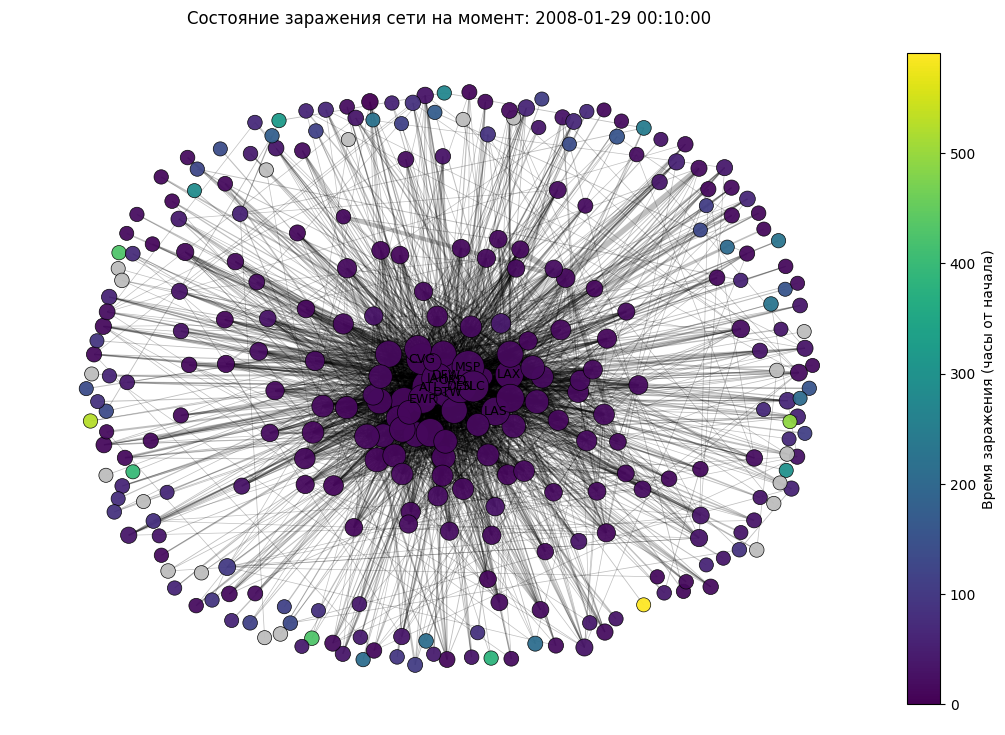

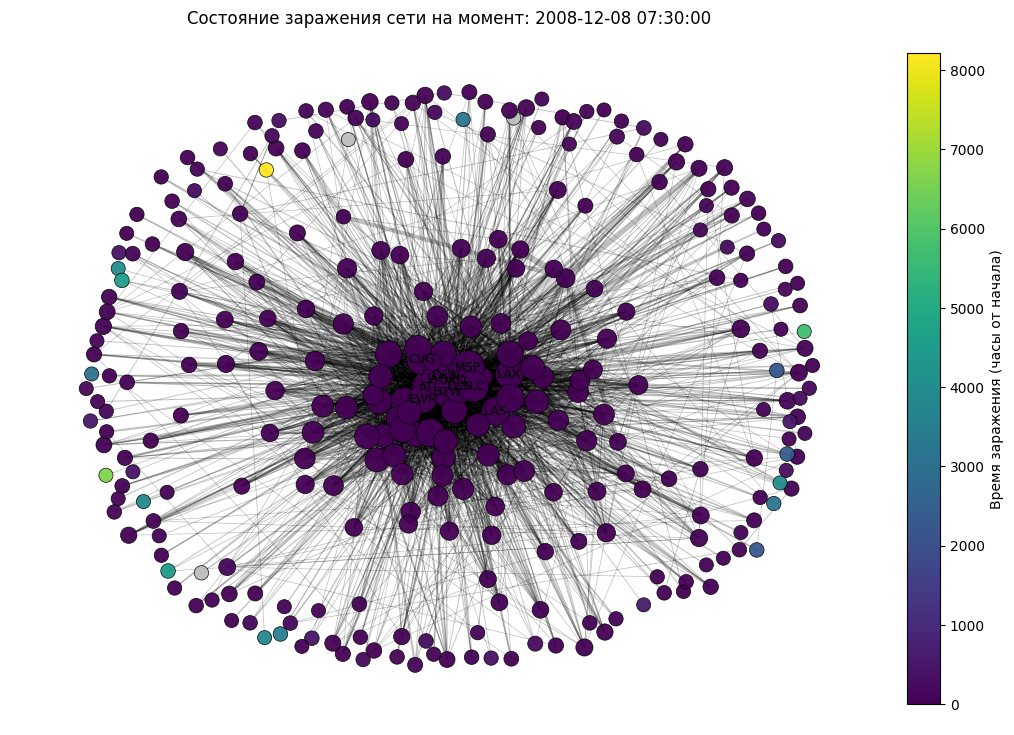

In [26]:
# Рисовалка
def build_undirected_graph_with_relative_weights(flights: pd.DataFrame) -> nx.Graph:
    counts = flights.groupby(["Origin","Dest"]).size().reset_index(name="cnt")
    total = counts['cnt'].sum()
    counts["pair"] = counts.apply(lambda r: tuple(sorted([r["Origin"], r["Dest"]])), axis=1)
    undirected = counts.groupby("pair")["cnt"].sum().reset_index()
    undirected[["A","B"]] = pd.DataFrame(undirected["pair"].tolist(), index=undirected.index)
    undirected["w"] = undirected["cnt"] / max(1, total)
    G = nx.Graph()
    for _, r in undirected.iterrows():
        a, b, w = r["A"], r["B"], float(r["w"])
        if pd.notna(a) and pd.notna(b) and a != b:
            G.add_edge(a, b, weight=w)
    return G

def visualize_infection_graph(
    flights: pd.DataFrame,
    infection_time_by_airport: dict,
    t_cutoff: "pd.Timestamp|None" = None,
    layout_seed: int = 42,
    label_top_k: int = 10,
):
    """
    flights — DataFrame с колонками event_time, Origin, Dest (уже отсортирован).
    infection_time_by_airport — результат run_si_simulation()[0], dict airport -> timestamp.
    t_cutoff — момент времени, на который хотим смотреть заражение (None => финальное состояние).
    """

    G = build_undirected_graph_with_relative_weights(flights)

    pos = nx.spring_layout(G, seed=layout_seed, weight="weight")
    fig, ax = plt.subplots(figsize=(12, 9))

    deg = dict(G.degree())
    max_deg = max(deg.values()) if len(deg) else 1

    # Толщина рёбер по весу
    edge_w = np.array([G[u][v].get("weight", 0.0) for u, v in G.edges()])
    if len(edge_w) == 0:
        edge_w_norm = []
    else:
        span = np.ptp(edge_w)  # вместо edge_w.ptp() (NumPy 2.0)
        if span == 0:
            span = 1.0
        edge_w_norm = 0.5 + 4.5 * (edge_w - edge_w.min()) / span

    if t_cutoff is None and len(infection_time_by_airport) > 0:
        t_cutoff = max(infection_time_by_airport.values())

    t0 = flights["event_time"].min()
    nodes = list(G.nodes())

    # Времена заражения в часах (NaN — не заражён к t_cutoff)
    times_hours = []
    for n in nodes:
        ts = infection_time_by_airport.get(n, None)
        if ts is None or (t_cutoff is not None and ts > t_cutoff):
            times_hours.append(np.nan)
        else:
            times_hours.append((ts - t0).total_seconds() / 3600.0)
    arr = np.array(times_hours, dtype=float)
    infected_mask = ~np.isnan(arr)

    # Цвета узлов: незаражённые — серые; заражённые — по градиенту viridis
    cmap = plt.cm.viridis
    node_colors = []
    norm = None
    if infected_mask.any():
        vmin = float(np.nanmin(arr))
        vmax = float(np.nanmax(arr))
        if vmax == vmin:
            vmax = vmin + 1e-9  # чтобы нормализация не делилась на 0
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        for val in arr:
            if np.isnan(val):
                node_colors.append("#BDBDBD")
            else:
                node_colors.append(cmap(norm(val)))
    else:
        node_colors = ["#BDBDBD"] * len(nodes)

    # Размер узла по степени
    node_sizes = [100 + 600 * (deg[n] / max_deg if max_deg > 0 else 0) for n in nodes]

    # Отрисовка
    nx.draw_networkx_edges(G, pos, width=edge_w_norm, alpha=0.25, ax=ax)
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodes,
        node_color=node_colors,
        node_size=node_sizes,
        linewidths=0.5,
        edgecolors="black",
        alpha=0.95,
        ax=ax
    )

    # Подписываем топ-узлы по степени
    if label_top_k and label_top_k > 0:
        top_nodes = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:label_top_k]
        labels = {n: n for n, _ in top_nodes}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, ax=ax)

    # Цветовая шкала только если есть заражённые
    if infected_mask.any() and norm is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # требование Matplotlib
        cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
        cbar.set_label("Время заражения (часы от начала)")

    title_time = f"{t_cutoff}" if t_cutoff is not None else "конец симуляции"
    ax.set_title(f"Состояние заражения сети на момент: {title_time}")
    ax.set_axis_off()
    plt.show()



infection_time_by_airport, timeline = run_si_simulation(flights, p=0.1, start_airport="ABE")

# 28 дней спустя...
t0 = flights["event_time"].min()
t_cut = t0 + pd.Timedelta(days=28)
visualize_infection_graph(flights, infection_time_by_airport, t_cutoff=t_cut, label_top_k=12)

# Финальное состояние:
visualize_infection_graph(flights, infection_time_by_airport, t_cutoff=None, label_top_k=12)



## Как инфекционность влияет на скорость распространения?

Для `p ∈ [0.01, 0.05, 0.1, 0.5, 1.0]` запустим по 10 симуляций, усредним результаты и каждые 12 часов посчитаем долю заражённых аэропортов.


In [27]:
def simulate_many_and_aggregate(
    flights: pd.DataFrame,
    ps=(0.01, 0.05, 0.1, 0.5, 1.0),
    runs_per_p: int = 10,
    start_airport: str = "ABE",
    step_hours: int = 12,
    random_seed: int = 123,
) -> pd.DataFrame:
    rng_base = random.Random(random_seed)

    airports = pd.unique(pd.concat([flights['Origin'], flights['Dest']], ignore_index=True)).tolist()
    total_airports = len(airports)
    if total_airports == 0:
        raise ValueError("В данных нет аэропортов.")

    t0, t1 = flights['event_time'].min(), flights['event_time'].max()
    time_grid = pd.date_range(start=t0, end=t1, freq=f"{step_hours}H")
    records = []

    for p in ps:
        curve_sum = np.zeros(len(time_grid), dtype=float)

        for _ in range(runs_per_p):
            rng_local = random.Random(rng_base.random() * 1e9)
            inf_map, _ = run_si_simulation(flights, p=p, start_airport=start_airport, rng_local=rng_local)
            infected_times_sorted = sorted(inf_map.values())

            counts = []
            j = 0
            for tg in time_grid:
                while j < len(infected_times_sorted) and infected_times_sorted[j] <= tg:
                    j += 1
                counts.append(j)
            curve_sum += np.array(counts, dtype=float) / total_airports

        curve_mean = curve_sum / runs_per_p
        for tg, sh in zip(time_grid, curve_mean):
            records.append({"p": p, "time": tg, "share_infected": sh})

    return pd.DataFrame(records)


agg_df = None
if flights is not None and len(flights) > 0:
    agg_df = simulate_many_and_aggregate(
        flights,
        ps=(0.01, 0.05, 0.1, 0.5, 1.0),
        runs_per_p=10,
        start_airport="ABE",
        step_hours=12,
        random_seed=2024,
    )
    display(agg_df.head())
else:
    print("Данные не загружены — пропустим расчёт.")


/tmp/ipython-input-2574061300.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_grid = pd.date_range(start=t0, end=t1, freq=f"{step_hours}H")


,p,time,share_infected
0,0.01,2008-01-01 00:10:00,0.003279
1,0.01,2008-01-01 12:10:00,0.003934
2,0.01,2008-01-02 00:10:00,0.007541
3,0.01,2008-01-02 12:10:00,0.014754
4,0.01,2008-01-03 00:10:00,0.023279


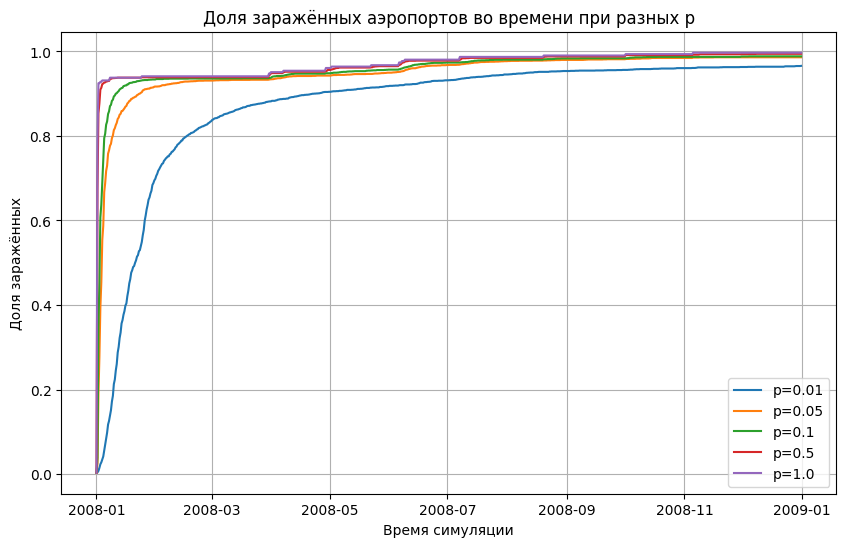

In [28]:

# Визуализация зависимостей доли заражённых от времени для разных p
if agg_df is not None:
    plt.figure(figsize=(10,6))
    for p_val, sub in agg_df.groupby('p'):
        sub = sub.sort_values('time')
        plt.plot(sub['time'], sub['share_infected'], label=f"p={p_val}")
    plt.title("Доля заражённых аэропортов во времени при разных p")
    plt.xlabel("Время симуляции")
    plt.ylabel("Доля заражённых")
    plt.grid(True)
    plt.legend()
else:
    print("Нет данных для графика.")



## Может ли информация о сети помочь предсказать, кто будет заражён?

1) Строим ненаправленный граф: вес ребра — относительное число рейсов между парой аэропортов.  
2) Запускаем 50 симуляций при `p=0.5` из `ABE`, считаем **медианное время заражения** каждого аэропорта.  
3) Считаем для каждого узла:
- коэффициент кластеризации `nx.clustering`,
- степень `nx.degree`,
- посредническую центральность `nx.betweenness_centrality` (с учётом весов).

Затем строим scatter-плоты и считаем корреляции Спирмана.


In [29]:
def build_undirected_graph_with_relative_weights(flights: pd.DataFrame) -> nx.Graph:
    counts = flights.groupby(["Origin","Dest"]).size().reset_index(name="cnt")
    total = counts['cnt'].sum()
    counts['pair'] = counts.apply(lambda r: tuple(sorted([r['Origin'], r['Dest']])), axis=1)
    undirected = counts.groupby('pair')['cnt'].sum().reset_index()
    undirected[['A','B']] = pd.DataFrame(undirected['pair'].tolist(), index=undirected.index)
    undirected['w'] = undirected['cnt'] / max(1, total)

    G = nx.Graph()
    for _, r in undirected.iterrows():
        a, b, w = r['A'], r['B'], float(r['w'])
        if pd.notna(a) and pd.notna(b) and a != b:
            G.add_edge(a, b, weight=w)
    return G


def median_infection_times(
    flights: pd.DataFrame,
    p: float = 0.5,
    start_airport: str = "ABE",
    runs: int = 50,
    random_seed: int = 2025,
) -> pd.Series:
    t0 = flights['event_time'].min()
    rng_base = random.Random(random_seed)
    per_node_times: Dict[str, List[float]] = defaultdict(list)

    for _ in range(runs):
        rng_local = random.Random(rng_base.random() * 1e9)
        inf_map, _ = run_si_simulation(flights, p=p, start_airport=start_airport, rng_local=rng_local)
        for ap, ts in inf_map.items():
            per_node_times[ap].append((ts - t0).total_seconds() / 3600.0)

    all_airports = pd.unique(pd.concat([flights['Origin'], flights['Dest']], ignore_index=True)).tolist()
    med = {}
    for a in all_airports:
        arr = per_node_times.get(a, [])
        med[a] = float(np.median(arr)) if arr else np.nan
    return pd.Series(med, name='median_time_hours')


metrics_df = None
if flights is not None and len(flights) > 0:
    G = build_undirected_graph_with_relative_weights(flights)
    print(f"Граф: |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}" )

    med_times = median_infection_times(flights, p=0.5, start_airport="ABE", runs=50)

    clustering = nx.clustering(G)  # без весов
    degree_dict = dict(G.degree())
    betw = nx.betweenness_centrality(G, weight='weight')  # с весами по условной транспортной интенсивности

    metrics_df = pd.DataFrame({
        'airport': list(G.nodes()),
        'clustering': [clustering.get(n, np.nan) for n in G.nodes()],
        'degree': [degree_dict.get(n, np.nan) for n in G.nodes()],
        'betweenness': [betw.get(n, np.nan) for n in G.nodes()],
    }).set_index('airport')
    metrics_df['median_time_hours'] = med_times
    display(metrics_df.head())
else:
    print("Граф и метрики не посчитаны — нет данных.")


Граф: |V|=305, |E|=2834


,clustering,degree,betweenness,median_time_hours
airport,,,,
ABE,0.833333,12,0.001032,0.000000
ATL,0.143232,173,0.127454,7.750000
BHM,0.747899,35,0.020993,8.166667
CLE,0.482807,76,0.000000,7.916667
CLT,0.396443,84,0.044871,7.583333


Спирман(clustering, median_time_hours) = 0.0713
Спирман(degree, median_time_hours) = -0.8779
Спирман(betweenness, median_time_hours) = -0.5640


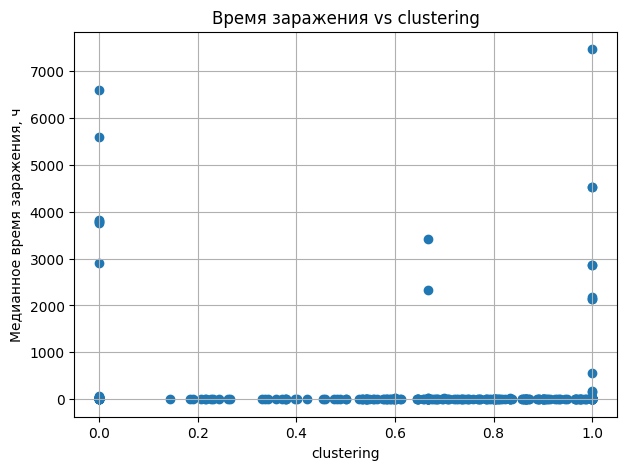

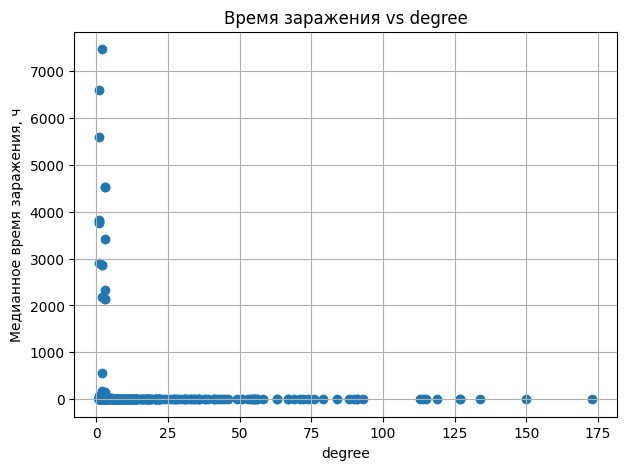

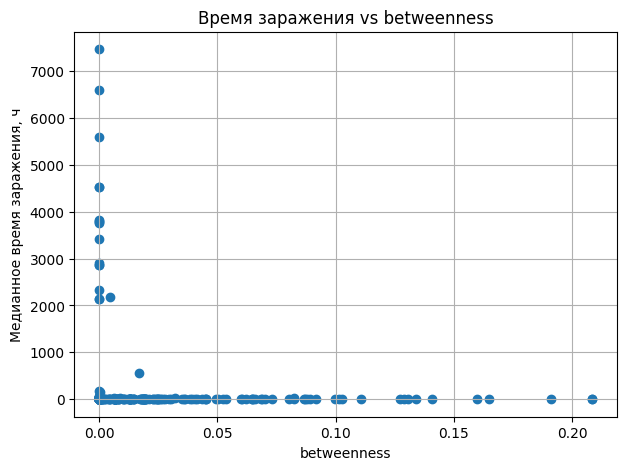

In [30]:
# Вспомогательная функция для Спирмана (через ранги)
def spearman_corr(x: pd.Series, y: pd.Series) -> float:
    df = pd.concat([x, y], axis=1).dropna()
    if len(df) < 3:
        return np.nan
    xr = df.iloc[:,0].rank()
    yr = df.iloc[:,1].rank()
    return xr.corr(yr)


if metrics_df is not None:
    for col in ['clustering','degree','betweenness']:
        plt.figure(figsize=(7,5))
        plt.scatter(metrics_df[col], metrics_df['median_time_hours'])
        plt.xlabel(col)
        plt.ylabel('Медианное время заражения, ч')
        plt.title(f'Время заражения vs {col}')
        plt.grid(True)

    for col in ['clustering','degree','betweenness']:
        r = spearman_corr(metrics_df[col], metrics_df['median_time_hours'])
        print(f"Спирман({col}, median_time_hours) = {r:.4f}")
else:
    print("Нет данных для scatter-плотов и корреляций.")



### Выводы
— Узлы с высокой степенью и большой посреднической центральностью чаще заражаются раньше: на них сходится больше маршрутов, и они лежат на кратчайших путях между многими парами аэропортов.  
— Кластеризация может давать слабее выраженную связь со временем заражения, так как отражает плотность локального окружения, а не положение в глобальной структуре сети.  
